In [28]:
from packaging import version
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
from pathlib import Path
import os
import scipy
from collections import defaultdict
from functools import partial
from  matplotlib.ticker import FuncFormatter
import torch
import numpy as np

In [29]:
def load_exp(exp_name):
    dir_path = Path("/home/xt0r3-user/cambridge/partii/dissertation/s3prl/s3prl/s3prl/result/downstream/")

    if not (dir_path / exp_name).exists():
        return {}

    dev_metric_line = ""

    with open(dir_path / exp_name / "log.log") as f:
        for line in f:
            test_metric_line = dev_metric_line
            dev_metric_line = line

    test_metrics_list = test_metric_line.split('|')[1:-1]
    dev_metrics_list = dev_metric_line.split('|')[1:-1]

    test_metrics = dict([
     tuple(metric_pair.split(':')) for metric_pair in test_metrics_list
    ])

    dev_metrics = dict([
     tuple(metric_pair.split(':')) for metric_pair in dev_metrics_list
    ])
    
    return {
        'test': test_metrics,
        'dev': dev_metrics,
    }
    # sns.lineplot(dfx, x='step', y='value', hue='name', errorbar=None)

In [30]:
models = [
    "wav2vec2",
    "wavlm_large",
    "multires_hubert_multilingual_large600k",
    "wavlablm_ms_40k",
    "hubert",
]

# metric_list = ['f1_score', 'recall', 'precision', 'loss', 'per']
# splits=['dev', 'test']
# parsed_metrics = []
# for split in splits:
#     for metric in metric_list:
#         parsed_metrics.append(f"{split}_{metric}")

In [31]:
metrics = defaultdict(dict)
for augmentation in models:
    for i in range(1, 6):
        metrics[augmentation][i]=(load_exp(f"model_{augmentation}_{i}"))
        # print(f"{i}_{augmentation}")
        # display(dfx.loc['dev_f1_score'].isna().any())
        # print(dfx.loc[metric]['value'])

df = pd.json_normalize(metrics)
df.columns = pd.MultiIndex.from_tuples(df.columns.str.split('.').to_series().apply(tuple))
df = df.stack(1).droplevel(0, axis=0).astype(float)
df = df.swaplevel(0, 1, axis=1)
df

dev                                                   \
         hubert                                                    
  corr_diag_pct deletions err_diag_pct  f1_score      fn      fp   
1      0.563631     540.0     0.298822  0.482508   376.0  1000.0   
2      0.518469    1797.0     0.337086  0.473885  1468.0  2963.0   
3      0.506751    1771.0     0.335471  0.463337  1563.0  2876.0   
4      0.504979    1913.0     0.358355  0.478922  1421.0  3100.0   
5      0.544278    1703.0     0.324610  0.482620  1409.0  3046.0   

                                                             ...        test  \
                                                             ... wavlm_large   
  global-f1-score global-per global-precision global-recall  ...  insertions   
1        0.564005   0.180927         0.470899      0.703002  ...       617.0   
2        0.550472   0.176804         0.477977      0.648888  ...       505.0   
3        0.540999   0.176259         0.476329      0.625987  ...       452.0   
4        0.549656   0.182576         0.470899      0.660048  ...       417.0   
5        0.554634   0.176837         0.476632      0.663160  ...       441.0   

                                                                               \
                                                                                
        loss num_ref_tokens        per precision    recall step substitutions   
1  20.133181        31187.0  15.534954  0.456097  0.510106  0.0        3353.0   
2  20.300358        31187.0  15.846690  0.460069  0.527022  0.0        3427.0   
3  17.727709        31187.0  15.383341  0.480067  0.550500  0.0        3269.0   
4  17.469305        31187.0  15.131537  0.487080  0.537641  0.0        3237.0   
5  17.369894        31187.0  15.264741  0.477159  0.551430  0.0        3285.0   

                    
                    
        tn      tp  
1  25303.0  2475.0  
2  25129.0  2533.0  
3  25146.0  2624.0  
4  25221.0  2575.0  
5  25140.0  2631.0  

[5 rows x 200 columns]

In [32]:
scipy.stats.ttest_ind(np.zeros(10), np.ones(10) + np.random.normal(0, 0.1, 10))

Ttest_indResult(statistic=-34.07132502471124, pvalue=8.425361130858272e-18)

In [33]:
metric_list = [
    'loss',
    'global-per',
    'global-precision',
    # 'global-recall',
    'global-f1-score',

]

In [34]:
splits = ['test', 'dev']

In [35]:
results = []
small_augs = list(set(models) - {"wav2vec2"})
for augmentation in small_augs:
    cur_res = []
    for split in splits:
        for metric in metric_list:
            result = scipy.stats.ttest_ind(
                df[(split, "wav2vec2", metric)].dropna(),
                df[(split, augmentation, metric)].dropna(),
            )
            cur_res.append(result.pvalue)
            cur_res.append(result.statistic)
    results.append(cur_res)

In [36]:
results[0]

[0.024583523179973154,
 -2.7623989347672318,
 0.15410218251181396,
 -1.5741391856633817,
 0.2029495572267452,
 1.3866973514279832,
 0.004139814571908281,
 -3.9663885405662223,
 0.012153667385204911,
 3.2246743255635204,
 0.0017026283263454002,
 4.623402386713994,
 0.0014426547772024814,
 -4.751397962653329,
 0.3796472600478421,
 -0.9298593855880609]

In [37]:
res_df = pd.DataFrame(
    results,
    index=small_augs,
    columns=pd.MultiIndex.from_product([splits, metric_list, ["pvalue", "statistic"]]),
).loc(axis=1)[:, :, :]#"pvalue"]

res_df.sort_values(by=('test', 'global-precision', 'pvalue')).style.highlight_between(color="green", right=0.05)

In [38]:
df.mean().index

MultiIndex([( 'dev',      'hubert',    'corr_diag_pct'),
            ( 'dev',      'hubert',        'deletions'),
            ( 'dev',      'hubert',     'err_diag_pct'),
            ( 'dev',      'hubert',         'f1_score'),
            ( 'dev',      'hubert',               'fn'),
            ( 'dev',      'hubert',               'fp'),
            ( 'dev',      'hubert',  'global-f1-score'),
            ( 'dev',      'hubert',       'global-per'),
            ( 'dev',      'hubert', 'global-precision'),
            ( 'dev',      'hubert',    'global-recall'),
            ...
            ('test', 'wavlm_large',       'insertions'),
            ('test', 'wavlm_large',             'loss'),
            ('test', 'wavlm_large',   'num_ref_tokens'),
            ('test', 'wavlm_large',              'per'),
            ('test', 'wavlm_large',        'precision'),
            ('test', 'wavlm_large',           'recall'),
            ('test', 'wavlm_large',             'step'),
            ('t

In [39]:
df.mean(axis=0).loc[:,:, metric_list].to_frame().unstack(1)

0                                         \
                          hubert multires_hubert_multilingual_large600k   
dev  loss              21.816332                              20.579965   
     global-per         0.178681                               0.169231   
     global-precision   0.474548                               0.489473   
     global-f1-score    0.551953                               0.558760   
test loss              22.568542                              21.568460   
     global-per         0.187293                               0.181037   
     global-precision   0.460548                               0.470075   
     global-f1-score    0.554559                               0.563210   

                                                              
                        wav2vec2 wavlablm_ms_40k wavlm_large  
dev  loss              21.826117       25.876417   18.949258  
     global-per         0.186787        0.195847    0.159659  
     global-precision   0.462039        0.435362    0.508201  
     global-f1-score    0.551991        0.528256    0.591297  
test loss              20.711362       26.835779   18.600089  
     global-per         0.175535        0.203927    0.155776  
     global-precision   0.479525        0.429750    0.513392  
     global-f1-score    0.544286        0.539612    0.559185

In [40]:

df.std(axis=0).loc[:,:, metric_list].to_frame().unstack(1)

0                                         \
                         hubert multires_hubert_multilingual_large600k   
dev  loss              0.516700                               0.801542   
     global-per        0.002872                               0.008063   
     global-precision  0.003388                               0.011127   
     global-f1-score   0.008365                               0.014927   
test loss              0.917372                               0.572949   
     global-per        0.008265                               0.007571   
     global-precision  0.013673                               0.013488   
     global-f1-score   0.004581                               0.006215   

                                                             
                       wav2vec2 wavlablm_ms_40k wavlm_large  
dev  loss              0.322833        0.231083    1.143801  
     global-per        0.002662        0.006237    0.003309  
     global-precision  0.006549        0.004173    0.010841  
     global-f1-score   0.006490        0.012176    0.004904  
test loss              0.391249        1.155190    1.482766  
     global-per        0.001943        0.006740    0.002652  
     global-precision  0.007089        0.007291    0.009429  
     global-f1-score   0.008671        0.008328    0.011325

In [41]:
df.std(axis=0).loc[:,:, metric_list].to_frame().unstack(1)

0                                         \
                         hubert multires_hubert_multilingual_large600k   
dev  loss              0.516700                               0.801542   
     global-per        0.002872                               0.008063   
     global-precision  0.003388                               0.011127   
     global-f1-score   0.008365                               0.014927   
test loss              0.917372                               0.572949   
     global-per        0.008265                               0.007571   
     global-precision  0.013673                               0.013488   
     global-f1-score   0.004581                               0.006215   

                                                             
                       wav2vec2 wavlablm_ms_40k wavlm_large  
dev  loss              0.322833        0.231083    1.143801  
     global-per        0.002662        0.006237    0.003309  
     global-precision  0.006549        0.004173    0.010841  
     global-f1-score   0.006490        0.012176    0.004904  
test loss              0.391249        1.155190    1.482766  
     global-per        0.001943        0.006740    0.002652  
     global-precision  0.007089        0.007291    0.009429  
     global-f1-score   0.008671        0.008328    0.011325

In [42]:
res_df
res_df.loc(axis=1)['test', :, 'pvalue']

test                \
                                            loss    global-per   
                                          pvalue        pvalue   
multires_hubert_multilingual_large600k  0.024584  1.541022e-01   
hubert                                  0.003148  1.473951e-02   
wavlablm_ms_40k                         0.000004  1.777449e-05   
wavlm_large                             0.015151  9.000740e-07   

                                                                         
                                       global-precision global-f1-score  
                                                 pvalue          pvalue  
multires_hubert_multilingual_large600k         0.202950        0.004140  
hubert                                         0.024863        0.047235  
wavlablm_ms_40k                                0.000004        0.409950  
wavlm_large                                    0.000205        0.047729

In [43]:
import re
latex = res_df.loc(axis=1)['test', :, 'pvalue'].sort_values(by=('test', 'global-precision', 'pvalue')).to_latex(float_format="%.2E")

latex = re.sub(
    r"(\d*)(\d).(\d)\d+E-01",
    r"\1.\2\3",
    latex
)

# latex = re.sub(
#     r"(\d*)(\d\d).\d+E-02",
#     r"\1.\2",
#     latex
# )

latex = re.sub(
    r"E(-\d+)",
    r"\\cdot 10^{\1}",
    latex
)

latex = latex.replace(' .', ' 0.') 


print(latex)

\begin{tabular}{lrrrr}
\toprule
 & \multicolumn{4}{r}{test} \\
 & loss & global-per & global-precision & global-f1-score \\
 & pvalue & pvalue & pvalue & pvalue \\
\midrule
wavlablm_ms_40k & 3.55\cdot 10^{-06} & 1.78\cdot 10^{-05} & 4.31\cdot 10^{-06} & 0.41 \\
wavlm_large & 1.52\cdot 10^{-02} & 9.00\cdot 10^{-07} & 2.05\cdot 10^{-04} & 4.77\cdot 10^{-02} \\
hubert & 3.15\cdot 10^{-03} & 1.47\cdot 10^{-02} & 2.49\cdot 10^{-02} & 4.72\cdot 10^{-02} \\
multires_hubert_multilingual_large600k & 2.46\cdot 10^{-02} & 0.15 & 0.20 & 4.14\cdot 10^{-03} \\
\bottomrule
\end{tabular}



In [44]:
models

['wav2vec2',
 'wavlm_large',
 'multires_hubert_multilingual_large600k',
 'wavlablm_ms_40k',
 'hubert']

In [45]:
name_map = {x: x for x in models}

name_map.update({
    "hubert": 'HuBERT \\cite{hsu2021hubert}',
    "wav2vec2": 'Wav2Vec2 \\cite{baevski2020wav2vec}',
    "wavlablm_ms_40k": 'WavLabLM \\cite{wavlablm}',
    "wavlm_large": 'WavLM large \\cite{wavlm}',
    "wavlm_base_plus": 'WavLM \\cite{wavlm}',
    "decoar2": 'DeCoAR 2.0 \\cite{decoar2}',
    "multires_hubert_multilingual_base": 'MR-HuBERT \\cite{multires-hubert}',
    "multires_hubert_multilingual_large600k": 'MR-HuBERT large (600k steps) \\cite{multires-hubert}',
    "multires_hubert_multilingual_large400k": 'MR-HuBERT large (400k steps) \\cite{multires-hubert}',
})

In [46]:
metric_map = {x: x for x in metric_list}

metric_map.update({
    'loss': 'Loss',
    'global-per': 'PER',
    'global-f1-score': "F1-score",
    'global-precision': "Precision",
})

In [47]:
dfmean = df['test'].mean().loc[:, metric_list].unstack(1).sort_values(by='global-f1-score').round(3)
dfstd = df['test'].std().loc[:, metric_list].unstack(1).sort_values(by='global-f1-score').round(3)
dfmean.iloc(axis=1)[0] = dfmean.iloc(axis=1)[0].round(2)
dfstd.iloc(axis=1)[0] = dfstd.iloc(axis=1)[0].round(2)

dfx = ("$" + dfmean.astype(str) + "\pm " + dfstd.astype(str) + "$")

dfx.index = dfx.index.to_series().map(name_map)
dfx.columns = dfx.columns.to_series().map(metric_map)

latex = dfx.to_latex().replace('_', '\_').replace('lllll', 'lrrrr')

# import re
# latex = res_df.loc(axis=1)['test', :, 'pvalue'].sort_values(by=('test', 'global-precision', 'pvalue')).to_latex(float_format="%.2E")

# latex = re.sub(
#     r"(\d*)(\d).(\d)\d+E-01",
#     r"\1.\2\3",
#     latex
# )

# # latex = re.sub(
# #     r"(\d*)(\d\d).\d+E-02",
# #     r"\1.\2",
# #     latex
# # )

# latex = re.sub(
#     r"E(-\d+)",
#     r"\\cdot 10^{\1}",
#     latex
# )

# latex = latex.replace(' .', ' 0.') 


print(latex)

\begin{tabular}{lllll}
\toprule
 & Loss & PER & Precision & F1-score \\
\midrule
HuBERT \cite{hsu2021hubert} & $22.57\pm 0.92$ & $0.187\pm 0.008$ & $0.461\pm 0.014$ & $0.555\pm 0.005$ \\
MR-HuBERT large (600k steps) \cite{multires-hubert} & $21.57\pm 0.57$ & $0.181\pm 0.008$ & $0.47\pm 0.013$ & $0.563\pm 0.006$ \\
Wav2Vec2 \cite{baevski2020wav2vec} & $20.71\pm 0.39$ & $0.176\pm 0.002$ & $0.48\pm 0.007$ & $0.544\pm 0.009$ \\
WavLabLM \cite{wavlablm} & $26.84\pm 1.16$ & $0.204\pm 0.007$ & $0.43\pm 0.007$ & $0.54\pm 0.008$ \\
WavLM large \cite{wavlm} & $18.6\pm 1.48$ & $0.156\pm 0.003$ & $0.513\pm 0.009$ & $0.559\pm 0.011$ \\
\bottomrule
\end{tabular}



In [48]:

pd.DataFrame(results, index=small_augs, columns=pd.MultiIndex.from_product([splits, metric_list, ['pvalue', 'statistic']])).loc(axis=1)[:, :, 'statistic'].style.highlight_between(color='green', right=-2)

In [49]:
history['dev_f1_score']

NameError: name 'history' is not defined

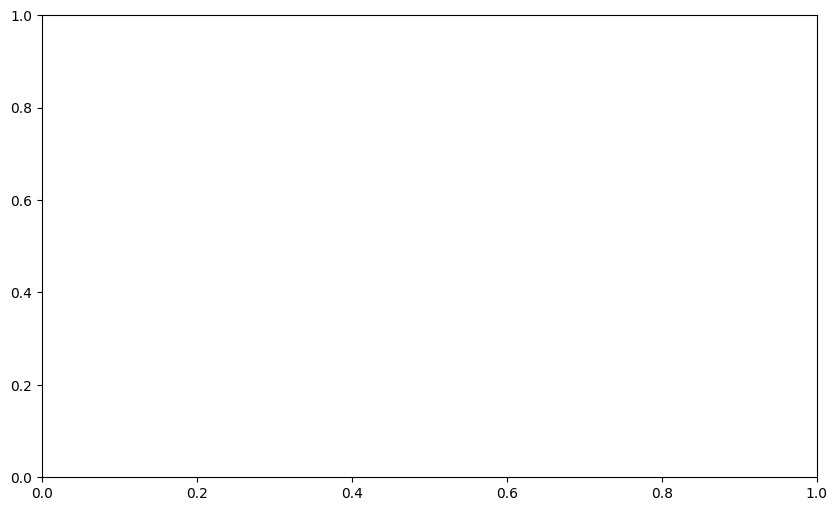

In [50]:
fig, ax = plt.subplots(figsize=(10, 6))
histories = [
            history[f"{split}_f1_score"][aug]
            .reset_index(drop=True)
            .rename(columns=lambda col: f"{aug} | {split}")
            .rename_axis(index="epoch", columns='f1 score')
    for split in ['dev', 'test']
    for aug in models
]

sns.lineplot(
            pd.concat(histories, axis=1),
            errorbar="sd",
            palette='colorblind'
        ).set(ylabel='f1 score',
xticks=list(range(0, 20, 2)))

plt.savefig('f1_scores.png')

# plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))

In [ ]:
scipy.stats.ttest_ind(
    history['test_f1_score']['phase_perturbation'].iloc[3],
    history['test_f1_score']['phase_perturbation'].iloc[15],
)

In [ ]:
history['test_f1_score']['phase_perturbation'].iloc[3]

In [ ]:
history['test_f1_score']['phase_perturbation'].iloc[19]